### Loading a dataset from the kaggle

### **Creating the dataset from the kaggle by using the kaggle api key**

> **Dataset Details**
*  Logo Classification challenges.
*  The logos are:
['Other', 'Starbucks', 'Subway', 'McDonalds', 'KFC', 'Burger King']


In [1]:
# Creating  dataset using the kaggle
!pip install kaggle --user kaggle
!export KAGGLE_USERNAME=dhurky
!export KAGGLE_KEY=f41f6bb6d33c29b130c4df1e28cf8084
!kaggle datasets download -d kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
!unzip logos-bk-kfc-mcdonald-starbucks-subway-none.zip

  Preparing metadata (setup.py) ... done
  Using cached certifi-2024.12.14-py3-none-any.whl.metadata (2.3 kB)
Using cached certifi-2024.12.14-py3-none-any.whl (164 kB)
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=786ef51fd35eb80df1817100b56e8929c7c9bd693d1c8113af9b0ba0602fb9a6
  Stored in directory: /root/.cache/pip/wheels/2b/af/a9/70bffa2773af622d2ebea9c8d407720b86e67bd40c465bf837
Successfully built kaggle
Dataset URL: https://www.kaggle.com/datasets/kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
License(s): DbCL-1.0
 98%|█████████████████████████████████████▍| 64.0M/65.0M [00:05<00:00, 13.8MB/s]
100%|██████████████████████████████████████| 65.0M/65.0M [00:06<00:00, 11.3MB/s]
/bin/bash: unzip: command not found


## **Defining a simple dataset for experimenting**


*  Logo Classification challenges.
*  The logos are:
['Other', 'Starbucks', 'Subway', 'McDonalds', 'KFC', 'Burger King']
*  Which is basically in ImageFolder format which have a utils in pytorch
*  Also Need to give trasnform along with loading the images
*  Dataloader is intilaised


In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import dataloader
from torchvision.transforms import Compose,Resize,ToTensor

# Define the train_transform using Compose
train_transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Define the test_transform using Compose
test_transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# create a training dataset
train_data=ImageFolder("../data/logos-bk-kfc-mcdonald-starbucks-subway-none/logos3/train",transform=train_transform)
train_dataloader=dataloader.DataLoader(train_data,batch_size=1,shuffle=True)

# creating a testdatase
test_data=ImageFolder("../data/logos-bk-kfc-mcdonald-starbucks-subway-none/logos3/test", transform=test_transform)
test_dataloader=dataloader.DataLoader(test_data,batch_size=1,shuffle=True)


sample_input, sample_label = next(iter(train_dataloader))
examples = next(iter(train_dataloader))

In [5]:
sample_input.dtype

torch.float32

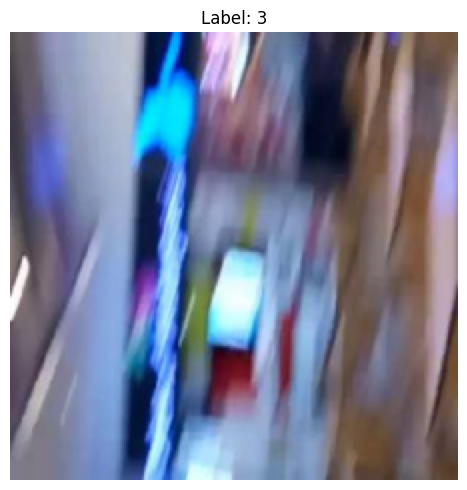

In [11]:
import matplotlib.pyplot as plt
import torch

def plot_first_batch(dataloader, n_images=8):
    """
    Plot the first batch of images from a DataLoader.

    Parameters:
        dataloader (torch.utils.data.DataLoader): DataLoader to fetch images from.
        n_images (int): Number of images to plot from the first batch. Default is 8.
    """
    # Get the first batch
    for images, labels in dataloader:
        break

    # Check if CUDA tensors and move to CPU for plotting
    if torch.is_tensor(images) and images.is_cuda:
        images = images.cpu()

    # Squeeze if images are grayscale
    if images.shape[1] == 1:
        images = images.squeeze(1)

    # Convert to numpy
    images = images.numpy()

    # Plot the first n_images
    n_images = min(n_images, len(images))  # Ensure n_images doesn't exceed batch size
    plt.figure(figsize=(15, 5))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        if len(images[i].shape) == 2:  # Grayscale
            plt.imshow(images[i], cmap="gray")
        else:  # RGB
            plt.imshow(images[i].transpose(1, 2, 0))  # Convert CHW to HWC
        plt.axis("off")
        plt.title(f"Label: {labels[i].item()}" if labels is not None else "No Label")
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have a DataLoader named `train_loader`
plot_first_batch(train_dataloader)


### **Swin Transformer**
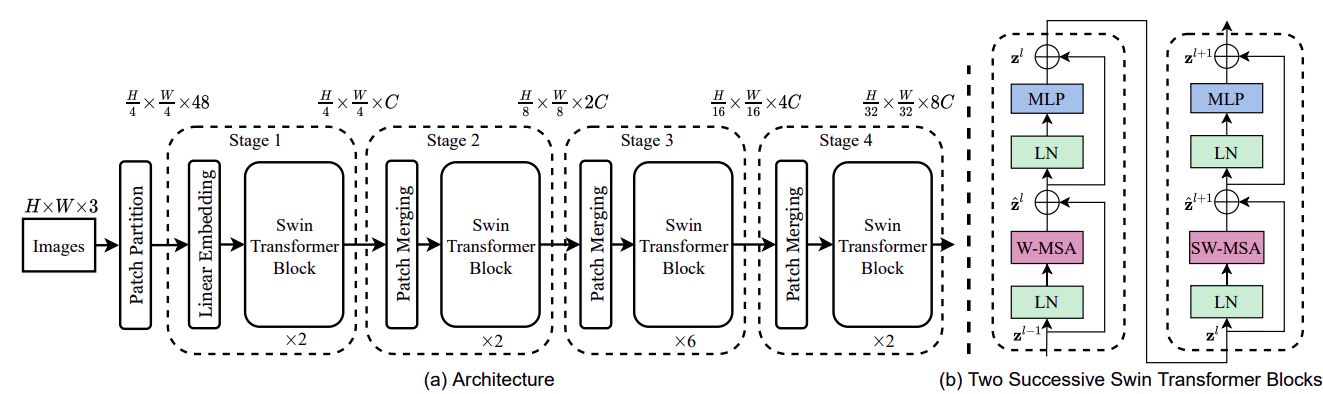



### **Transformer Configs**

Reference repo:

* https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py

* https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py

**Basic config for the SWIN transformer class**

    
    Implements Swin Transformer from the `"Swin Transformer: Hierarchical Vision Transformer using
    Shifted Windows" <https://arxiv.org/pdf/2103.14030>`_ paper.
    Args:
        patch_size (List[int]): Patch size.
        embed_dim (int): Patch embedding dimension.
        depths (List(int)): Depth of each Swin Transformer layer.
        num_heads (List(int)): Number of attention heads in different layers.
        window_size (List[int]): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.0.
        dropout (float): Dropout rate. Default: 0.0.
        attention_dropout (float): Attention dropout rate. Default: 0.0.
        stochastic_depth_prob (float): Stochastic depth rate. Default: 0.1.
        num_classes (int): Number of classes for classification head. Default: 1000.
        block (nn.Module, optional): SwinTransformer Block. Default: None.
        norm_layer (nn.Module, optional): Normalization layer. Default: None.
        downsample_layer (nn.Module): Downsample layer (patch merging). Default: PatchMerging.
    `


In [12]:
patch_size=[4,4]
embed_dim = 96
depths=[2, 2, 6, 2],
num_heads=[3, 6, 12, 24]
window_size=[7, 7]

# **Patch Partition Block**
As you can see the above SWIN transformer diagram you can see the patch partition block where it will convert the images into the patch of tokens using conv2d layer and aplly layer norm at last

In [13]:
from torch import nn
import torch
class PatchPartition(nn.Module):
  def __init__(self, in_channels, patch_size, embed_dims, patch_norm_needed:bool = True):
    super().__init__()
    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.embedding = nn.Conv2d(in_channels=in_channels, out_channels=self.embed_dim,kernel_size=tuple(self.patch_size), stride=tuple(self.patch_size))
    self.patch_norm_needed = patch_norm_needed
    if self.patch_norm_needed:
      self.patch_norm = nn.LayerNorm(self.embed_dim)
  def forward(self, x: torch.Tensor):
    x=self.embedding(x)
    x = x.permute(0,2,3,1)
    B,H,W,C = x.shape
    x = x.reshape(B,-1,C)
    if self.patch_norm_needed:
      x=self.patch_norm(x)
    return x

partition_layer=PatchPartition(in_channels=3, patch_size=patch_size,embed_dims=embed_dim)
partition_layer(sample_input).shape

torch.Size([1, 3136, 96])

In [12]:
import torch
sample_input = torch.rand(32, 784, 192)
sample_input.shape

torch.Size([32, 784, 192])

In [13]:
sample_input.unsqueeze(0).shape

torch.Size([1, 32, 784, 192])

In [14]:
sample_input.shape

torch.Size([32, 784, 192])

# **Patch Merging**

Merge the patch with the given factor

good reference for the patch merging code:
https://amaarora.github.io/posts/2022-07-04-swintransformerv1.html#patch-merging-layer



In [ ]:
class PatchMerging(nn.Module):
  def __init__(self,dim):
     super().__init__()
     self.dim=dim
     self.norm_layer=nn.LayerNorm(self.dim*4)
     self.linear_layer=nn.Linear(self.dim*4,self.dim*2)
  def forward(self, x: torch.Tensor)->torch.Tensor:
    B,HW,C = x.shape
    H=W=int(HW**(1/2))
    print(H)

    x=x.reshape(B,H,W,C)
    x0=x[:,0::2,0::2,:]
    x1=x[:,1::2,0::2,:]
    x2=x[:,0::2,1::2,:]
    x3=x[:,1::2,1::2,:]
    x=torch.cat((x0,x1,x2,x3),-1)
    x=x.view(B, -1, x.shape[-1])
    x=self.norm_layer(x)
    x=self.linear_layer(x)


    return x
patch_merging = PatchMerging(dim=96)
patch_merging(partition_layer(sample_input)).shape


56


torch.Size([32, 784, 192])

# **Shifted Window Attention**

* started understanding the code for shifted window attention using pytorch torchvision code base
* Important configs that is used for the Shifted Window Attention fucntioin

```
window_size = [7,7]
num_head = [3, 6, 12, 24]

shift_size = [0,0] or [7//2,7//2]


```

# **Transformer block building**

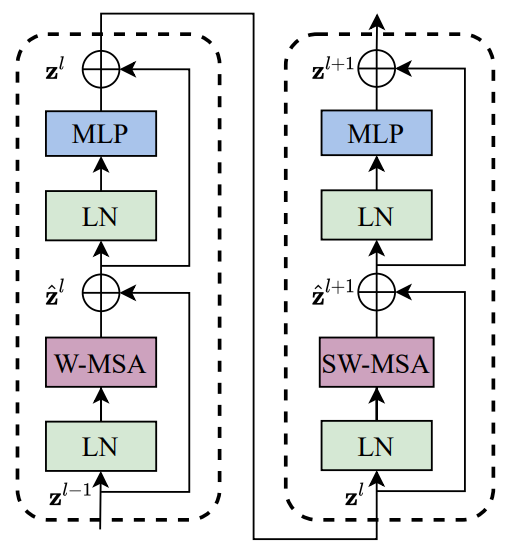

* Swin transformer block consists of Two Successive Transformer Blocks one with **Windowed**-MSA and other one contains **Shifted Window** - MSA
* In this we need to build
      * MLP block
      * W-MSA and SW-MSA
*

In [ ]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowMultiHeadAttention(nn.Module):
  def __init__(self,dim, input_resolution,window_size, num_head, shift_size):
    super().__init__()
    self.dim=dim
    self.window_size=window_size
    self.num_head=num_head
    self.shift_size=shift_size
    self.input_resolution=input_resolution
    self.qkv = nn.Linear(dim, 3*dim,bias=True)

    # define a parameter table of relative position bias
    self.relative_position_bias_table = nn.Parameter(
        torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_head))  # 2*Wh-1 * 2*Ww-1, nH

    # get pair-wise relative position index for each token inside the window
    coords_h = torch.arange(self.window_size[0])
    coords_w = torch.arange(self.window_size[1])
    coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
    relative_coords[:, :, 1] += self.window_size[1] - 1
    relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
    relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
    self.register_buffer("relative_position_index", relative_position_index)


    # adding attention mask
    if self.shift_size > 0:
      H,W = self.input_resolution
      img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
      h_slices =[slice(0,-self.window_size[0]),slice(-self.window_size[0], -self.shift_size),slice(-self.shift_size,None)]
      w_slices = [slice(0,-self.window_size[1]),slice(-self.window_size[1], -self.shift_size),slice(-self.shift_size,None)]
      cnt=0
      
      for i in h_slices:
        for j in w_slices:
          img_mask[:,i,j,:]=cnt
          cnt+=1

      mask_windows = window_partition(img_mask, self.window_size[0])  # nW, window_size, window_size, 1
        
      mask_windows = mask_windows.view(-1, self.window_size[0] * self.window_size[1])
      attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
      attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))        
          
    else:
      attn_mask = None

    self.register_buffer("attn_mask", attn_mask)

  def forward(self,x):
    """
    * Input shape : B * (input_resolution x input_resolution) * dim
    * Parition into windows
    """
    B_,T,C=x.shape #  B * (input_resolution x input_resolution) * dim
    # reshape to input resolution
    x=x.view(B_,self.input_resolution[0],self.input_resolution[1],C) # B * input_resolution * input_resolution * dim

    if self.shift_size > 0:
      x = torch.roll(x,shifts=(-self.shift_size,-self.shift_size), dims=(1, 2))
      x=window_partition(x,window_size=self.window_size[0]) # (B x nW) * (window_size * windoe_size) * dim

    else:
      x=window_partition(x,window_size=self.window_size[0]) # (B x nW) * (window_size * windoe_size) * dim



    # partion with windows and added all in the dimentions
    B_,wh,ww,dim=x.shape
    x=x.view(B_,-1,dim)
    x = self.qkv(x).reshape(B_,wh*ww,3,self.num_head,dim//self.num_head).permute(2,0,3,1,4)
    q,k,v=x[0],x[1],x[2]
    head_dim = (dim//self.num_head)**-0.5
    q = q * head_dim
    attn = (q @ k.transpose(-2, -1))

    relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)

    relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
    attn = attn + relative_position_bias.unsqueeze(0)

    print("Values shape:", v.shape)
    print("Attn score:", attn.shape)
    print("Attn mask:",self.attn_mask.shape)
    if self.attn_mask is not None:
      nW = self.attn_mask.shape[0]
      attn=attn.view(B_//nW, nW, self.num_head,49,49).sh
      print(self.attn_mask.unsqueeze(1).unsqueeze(0))


      
      attn = attn + self.attn_mask.unsqueeze(1)
    else:
      pass








    return x




input_resolution=(14,14)
dim=96
head=12
window_block=WindowMultiHeadAttention(dim=dim,input_resolution=input_resolution,num_head=head,window_size=[7,7],shift_size=3)
input_data=torch.ones((1,input_resolution[0]*input_resolution[1],dim))

window_block(input_data).shape


Values shape: torch.Size([4, 12, 49, 8])
Attn score: torch.Size([4, 12, 49, 49])
Attn mask: torch.Size([4, 49, 49])
torch.Size([1, 4, 12, 49, 49])
torch.Size([1, 4, 1, 49, 49])


torch.Size([3, 4, 12, 49, 8])

In [ ]:
def create_mask(input_resolution,window_size):
  h,w=input_resolution
  masks=torch.zeros(h,w)
  window_size=7
  shift_size=window_size//2
  x=[slice(0,-window_size),slice(-window_size, -shift_size),slice(-shift_size, None)]
  y=[slice(0,-window_size),slice(-window_size, -shift_size),slice(-shift_size, None)]
  cnt=0
  for i in x:
    for j in y:
      masks[i,j]=cnt
      cnt+=1
  masks=masks.unsqueeze(0).unsqueeze(3)
  print(masks.shape)
  masks=window_partition(masks,window_size=window_size)
  masks=masks.view(masks.shape[0],-1,1)
  # it check relationship between each patches insie dthe each window, to remove unwanted relationship after cyclic shift
  # we are doing masking that we need calcualte relationship only amoong same window patches
  new_mask = torch.clone(masks).permute(0,2,1)
  final_masks=masks-new_mask
  attn_mask = final_masks.masked_fill(final_masks != 0, float(-100.0)).masked_fill(final_masks == 0, float(0.0))
  return final_masks
create_mask(input_resolution,window_size=7).shape



torch.Size([1, 14, 14, 1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[   0.,    0.,    0.,  ..., -100., -100., -100.],
        [   0.,    0.,    0.,  ..., -100., -100., -100.],
        [   0.,    0.,    0.,  ..., -100., -100., -100.],
        ...,
        [-100., -100., -100.,  ...,    0.,    0.,    0.],
        [-100., -100., -100.,  ...,    0.,    0.,    0.],
        [-100., -100., -100.,  ...,    0.,    0.,    0.]])
tensor([[   0.,    0.,    0.,  ..., -100., -100., -100.],
        [   0.,    0.,    0.,  ..., -100., -100., -100.],
        [   0.,    0.,    0.,  ..., -100., -100., -100.],
        ...,
        [-100., -100., -100.,  ...,    0.,    0.,    0.],
        [-100., -100., -100.,  ...,    0.,    0.,    0.],
        [-100., -100., -100.,  ...,    0.,    0.,    0

torch.Size([4, 49, 49])

In [ ]:
import torch
window_size=7
num_heads=12
torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads).shape

torch.Size([169, 12])

In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self,dim, input_resolution,num_heads,window_size,shift_size=0,mlp_ratio=4.0):
      super().__init__()
      self.dim=dim
      self.input_resolution=input_resolution
      self.num_heads=num_heads
      self.window_size=window_size
      self.shift_size=shift_size
      self.mlp_ratio=mlp_ratio
      self.layer_norm=nn.LayerNorm(dim)

    def forward(self,x):
      x=self.layer_norm(x)

      return x





input_resolution=(14,14)
dim=1
head=12
swin_block=SwinTransformerBlock(dim=dim,input_resolution=input_resolution,num_heads=head,window_size=(7,7),shift_size=3)
input_data=torch.ones((1,input_resolution[0]*input_resolution[1],dim))
swin_block(input_data).shape


torch.Size([1, 196, 1])

In [ ]:
class ShiftedWindowAttention(nn.Module):
    """
    See :func:`shifted_window_attention`.
    """

    def __init__(
        self,
        dim: int,
        window_size: List[int],
        shift_size: List[int],
        num_heads: int,
        qkv_bias: bool = True,
        proj_bias: bool = True,
        attention_dropout: float = 0.0,
        dropout: float = 0.0,
    ):
        super().__init__()
        if len(window_size) != 2 or len(shift_size) != 2:
            raise ValueError("window_size and shift_size must be of length 2")
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.attention_dropout = attention_dropout
        self.dropout = dropout

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim, bias=proj_bias)

        self.define_relative_position_bias_table()
        self.define_relative_position_index()

    def define_relative_position_bias_table(self):
        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads)
        )  # 2*Wh-1 * 2*Ww-1, nH
        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)

    def define_relative_position_index(self):
        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).flatten()  # Wh*Ww*Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

    def get_relative_position_bias(self) -> torch.Tensor:
        return _get_relative_position_bias(
            self.relative_position_bias_table, self.relative_position_index, self.window_size  # type: ignore[arg-type]
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x (Tensor): Tensor with layout of [B, H, W, C]
        Returns:
            Tensor with same layout as input, i.e. [B, H, W, C]
        """
        relative_position_bias = self.get_relative_position_bias()
        return shifted_window_attention(
            x,
            self.qkv.weight,
            self.proj.weight,
            relative_position_bias,
            self.window_size,
            self.num_heads,
            shift_size=self.shift_size,
            attention_dropout=self.attention_dropout,
            dropout=self.dropout,
            qkv_bias=self.qkv.bias,
            proj_bias=self.proj.bias,
            training=self.training,
        )


0

In [ ]:
dim=96
qkv = nn.Linear(dim, dim * 3, bias=False)
qkv_output = qkv(partition_layer(sample_input))
qkv_output.shape
# qkv.weight.shape

torch.Size([32, 3136, 288])

In [ ]:
partition_layer(sample_input).shape

torch.Size([32, 3136, 96])

In [ ]:
qkv.weight.shape

torch.Size([288, 96])

In [ ]:
x0 = temp[:,0::2,0::2,:]
x1 = temp[:, 1::2, 0::2, :]  # B H/2 W/2 C
x2 = temp[:, 0::2, 1::2, :]  # B H/2 W/2 C
x3 = temp[:, 1::2, 1::2, :]  # B H/2 W/2 C

torch.cat((x0, x1, x2, x3),-1).shape

torch.Size([32, 28, 28, 384])

In [ ]:
torch.equal(temp[:,1,0,:],x1[:,0,0,:])

True